When doing a golum ((Januqart et al)[https://arxiv.org/pdf/2105.04536.pdf]) analyses, one first need to analyze the first image, doing a Bilby run but including the Morse factor in the waveform. If the GW displays higher-order modes and is a type II image (hence n = 0.5), then we can detect that feature. Here, we look at such an analysis.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import bilby
from golum.tools import waveformmodels # module including the adapted waveform
from golum.pe import prior # some module with discrete priors for the Morse factor

This analyis is similar to the one for bilby (see (bilby notebook)[https://git.ligo.org/justin.janquart/lensing-data-analysis-tutorials/-/blob/main/Basic_bilby_tutorial.ipynb]), except that we need to include the Morse factor. In addition, for lensing, the luminosity distance and geocentric time are modified. So, here, their values correspond to the apparent ones. 

Here, we also take an event with important HOM content to make the Morse factor apparent. Therefore, we use a low mass ratio, high total mass and a high inclination. The total SNR is also quite boosted to make sure we can properly see the various effects.

In [2]:
parameters = {"mass_1": 90.,
            "mass_2": 20.,
            "a_1": 0.6,
            "a_2": 0.4,
            "tilt_1": 1.1,
            "tilt_2": 0.7,
            "phi_12": 4.2,
            "phi_jl": 3.7,
            "luminosity_distance":500.,
            "ra": 3.055675141320019,
            "dec": -0.3817977049037472,
            "phase": 1.3,
            "psi": 0.7,
            "theta_jn": np.pi/3,
            "n_phase": 0.5,
            "geocent_time": 1126259642.413}

In [3]:
# just a copy of the parameters as a type I image to see the difference
parameters_typeI = {"mass_1": 90.,
            "mass_2": 20.,
            "a_1": 0.6,
            "a_2": 0.4,
            "tilt_1": 1.1,
            "tilt_2": 0.7,
            "phi_12": 4.2,
            "phi_jl": 3.7,
            "luminosity_distance":500.,
            "ra": 3.055675141320019,
            "dec": -0.3817977049037472,
            "phase": 1.3,
            "psi": 0.7,
            "theta_jn": np.pi/3,
            "n_phase": 0,
            "geocent_time": 1126259642.413}
parameters_tI_shifted = {"mass_1": 90.,
            "mass_2": 20.,
            "a_1": 0.6,
            "a_2": 0.4,
            "tilt_1": 1.1,
            "tilt_2": 0.7,
            "phi_12": 4.2,
            "phi_jl": 3.7,
            "luminosity_distance":500.,
            "ra": 3.055675141320019,
            "dec": -0.3817977049037472,
            "phase": 1.3 + np.pi/4., # this should mimick type II if the phase and Morse factor are degenerate
            "psi": 0.7,
            "theta_jn": np.pi/3,
            "n_phase": 0,
            "geocent_time": 1126259642.413}

In [4]:
# setup the usual bilby information 
outdir = "Outdir_typeII_image_analysis"
label = "TypeII_image_analysis"
duration = 4.
sampling_frequency = 2048.
minimumum_frequency = 20.
bilby.core.utils.setup_logger(outdir = outdir, label = label)

We can now set up the waveform arguments. However, since we want to include the Morse factor, which is is not a standard CBC parameter, we need to use a different frequency domain source model. Here, we use `golum.tools.waveformmodels.lensed_bbh_model`, which is an adaptation of the usual `bilby.gw.source.lal_binary_black_hold` multiplied by the overall Morse factor shift.

In [5]:
# setup the waveform generator 
waveform_arguments = dict(waveform_approximant = "IMRPhenomXPHM",
                          reference_frequency = 50.,
                          minimum_frequency = 20.)
waveform_generator = bilby.gw.WaveformGenerator(duration = duration,
                                                sampling_frequency = sampling_frequency,
                                                frequency_domain_source_model = waveformmodels.lensed_bbh_model,
                                                waveform_arguments = waveform_arguments)

10:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: golum.tools.waveformmodels.lensed_bbh_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


To check the effect of the Morse factor, we can look at the change in polarization for type I, type II, and type II with a shifted phase. If the two last do not match, this shows that the two are not equivalent and one can effectively detect the lensing feature by doing parameter estimation.

In [6]:
typeI_polas = waveform_generator.frequency_domain_strain(parameters = parameters_typeI)
typeI_shifted_polas = waveform_generator.frequency_domain_strain(parameters = parameters_tI_shifted)
typeII_polas = waveform_generator.frequency_domain_strain(parameters = parameters)

/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(20.0, 100.0)

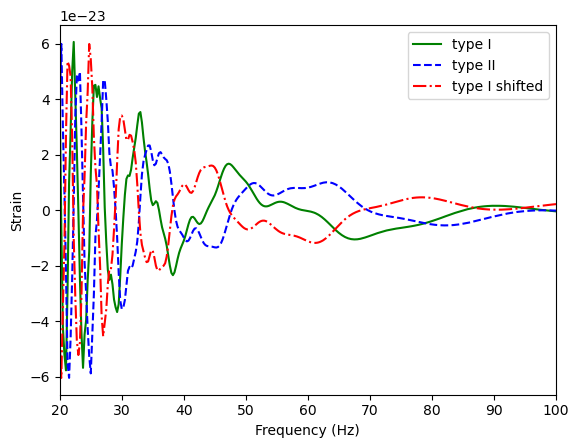

In [7]:
plt.figure()
plt.plot(waveform_generator.frequency_array, typeI_polas['plus'], label = 'type I', color = 'green')
plt.plot(waveform_generator.frequency_array, typeII_polas['plus'], label = 'type II', color = 'blue', ls = '--')
plt.plot(waveform_generator.frequency_array, typeI_shifted_polas['plus'], label = 'type I shifted', ls = '-.',
         color = 'red')
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.xlim(20, 100) #zoom to have a better view on what is going on 

We see that the three do not match, meaning that the lensing feature can be detected in a parameter estimation run.

We can inject the waveforms in the noise, and do the parameter estimation run to see what happens. 
To make sure your noise is reproduceable from one run to the other, you can also fix its realization by using the usual numpy seeding arguments.

In [8]:
np.random.seed(170814) # to fix the seed 
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1", "K1"])
interferometers.set_strain_data_from_power_spectral_densities(duration = duration,
                                                              sampling_frequency = sampling_frequency,
                                                              start_time = parameters['geocent_time'] - duration + 2)
interferometers.inject_signal(waveform_generator = waveform_generator,
                              parameters = parameters)

10:53 bilby INFO    : Injected signal in H1:
10:53 bilby INFO    :   optimal SNR = 36.60
10:53 bilby INFO    :   matched filter SNR = 37.53-0.91j
10:53 bilby INFO    :   mass_1 = 90.0
10:53 bilby INFO    :   mass_2 = 20.0
10:53 bilby INFO    :   a_1 = 0.6
10:53 bilby INFO    :   a_2 = 0.4
10:53 bilby INFO    :   tilt_1 = 1.1
10:53 bilby INFO    :   tilt_2 = 0.7
10:53 bilby INFO    :   phi_12 = 4.2
10:53 bilby INFO    :   phi_jl = 3.7
10:53 bilby INFO    :   luminosity_distance = 500.0
10:53 bilby INFO    :   ra = 3.055675141320019
10:53 bilby INFO    :   dec = -0.3817977049037472
10:53 bilby INFO    :   phase = 1.3
10:53 bilby INFO    :   psi = 0.7
10:53 bilby INFO    :   theta_jn = 1.0471975511965976
10:53 bilby INFO    :   n_phase = 0.5
10:53 bilby INFO    :   geocent_time = 1126259642.413
10:53 bilby INFO    : Injected signal in L1:
10:53 bilby INFO    :   optimal SNR = 28.08
10:53 bilby INFO    :   matched filter SNR = 28.66+0.56j
10:53 bilby INFO    :   mass_1 = 90.0
10:53 bilby I

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

To start the parameter estimation run, we need to setup a prior, this time also in a way that include the Morse factor. Here, we fix most of the parameters to make the parameter estimation run go faster. If you want to run for higher dimensionality, then you can simply unfreeze the parameters and use the default bilby priors.

Here, we use a discrete uniform prior for the Morse factor. If one wants, one can also use a continuous uniform prior between 0 and 1. Then, the prior can be set up using the usual uniform bilby prior. 

In [9]:
# setup the prior
priors = bilby.gw.prior.BBHPriorDict()
# sampling the mass ratio, mass ratio and phase as "usual" parameters
for key in ["a_1", "a_2", "tilt_1", "tilt_2", "phi_12", "phi_jl", "psi", "ra", "dec", "geocent_time", 
             "luminosity_distance", "theta_jn"]:
    priors[key] = parameters[key]

# for the Morse factor, we set up a discrete uniform prior between the three possible values (0, 0.5, 1.)
priors["n_phase"] = prior.MorseFactorPrior(name = "n_phase", latex_label = r"n_{1}")

10:53 bilby INFO    : No prior given, using default BBH priors in /Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


Text(0.5, 0, 'n')

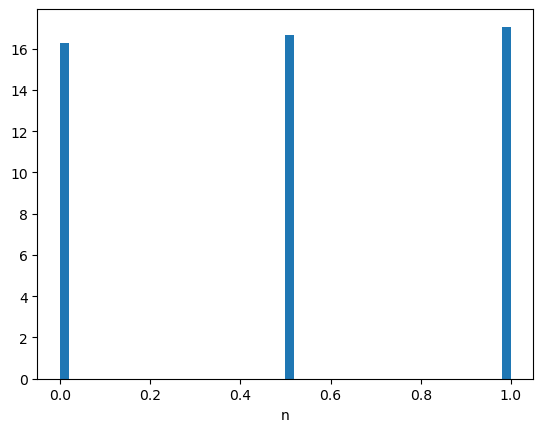

In [10]:
# you can plot the prior to check what it looks like
n_prior_samples = priors['n_phase'].sample(10000)

plt.figure()
plt.hist(n_prior_samples, bins = 50, histtype='stepfilled', density = True)
plt.xlabel("n")

For the first image analysis (or, equivalently, the type II image search), one can simply use the usual bilby likelihood. Som we set up the likelihood the usual way.

In [11]:
likelihood = bilby.gw.GravitationalWaveTransient(interferometers = interferometers,
                                                 waveform_generator = waveform_generator,
                                                 priors = priors)

In [12]:
# we can setup and start the sampler the same way as usual 
result = bilby.run_sampler(likelihood=likelihood, priors=priors, sampler="dynesty",
                           npoints=1000, npool = 4,
                           outdir=outdir, label=label)

# heavier settings for the full dimension analysis and asking for 16 cores
#result = bilby.run_sampler(likelihood=likelihood, priors=priors, sampler="dynesty",
#                           npoints=1000, npool = 16, naccept = 60, check_point_plot = True,
#                           check_point_delta_t = 1800, print_method = 'interval-60',
#                           samples = 'acceptance-walk', injection_parameters=parameters,
#                           outdir=outdir, label=label)

10:53 bilby INFO    : Running for label 'TypeII_image_analysis', output will be saved to 'Outdir_typeII_image_analysis'
10:53 bilby INFO    : Using lal version 7.3.1
10:53 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
10:53 bilby INFO    : Using lalsimulation version 5.2.1
10:53 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
10:53 bilby INFO    : Analysis priors:
10:53 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
10:53 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mat

5138it [10:09,  4.33it/s, bound:295 nc: 68 ncall:2.2e+05 eff:2.3% logz-ratio=551.01+/-0.10 dlogz:684.037>0.1]  

11:03 bilby INFO    : Written checkpoint file Outdir_typeII_image_analysis/TypeII_image_analysis_resume.pickle
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:749: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
11:03 bilby WARNING : Axis limits cannot be NaN or Inf
11:03 bilby WARNING : Failed to create dynesty run plot at checkpoint


8430it [20:29,  4.26it/s, bound:580 nc: 62 ncall:4.2e+05 eff:2.0% logz-ratio=1100.59+/-0.09 dlogz:152.368>0.1]

11:14 bilby INFO    : Written checkpoint file Outdir_typeII_image_analysis/TypeII_image_analysis_resume.pickle
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:749: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
11:14 bilby WARNING : Axis limits cannot be NaN or Inf
11:14 bilby WARNING : Failed to create dynesty run plot at checkpoint


12033it [30:52,  5.46it/s, bound:837 nc: 28 ncall:6.1e+05 eff:2.0% logz-ratio=1227.77+/-0.07 dlogz:22.877>0.1]

11:24 bilby INFO    : Written checkpoint file Outdir_typeII_image_analysis/TypeII_image_analysis_resume.pickle
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:749: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
11:24 bilby WARNING : Axis limits cannot be NaN or Inf
11:24 bilby WARNING : Failed to create dynesty run plot at checkpoint


16039it [41:02,  6.36it/s, bound:1088 nc: 39 ncall:7.8e+05 eff:2.1% logz-ratio=1245.44+/-0.07 dlogz:1.560>0.1]

11:34 bilby INFO    : Written checkpoint file Outdir_typeII_image_analysis/TypeII_image_analysis_resume.pickle
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:749: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
11:34 bilby WARNING : Axis limits cannot be NaN or Inf
11:34 bilby WARNING : Failed to create dynesty run plot at checkpoint


18737it [47:29,  6.87it/s, bound:1265 nc:  1 ncall:9.0e+05 eff:2.2% logz-ratio=1246.38+/-0.12 dlogz:0.024>0.1]

11:41 bilby INFO    : Written checkpoint file Outdir_typeII_image_analysis/TypeII_image_analysis_resume.pickle
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:749: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/janqu001/anaconda3/envs/SummerSchoolEnv/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
11:41 bilby WARNING : Axis limits cannot be NaN or Inf
11:41 bilby WARNING : Failed to create dynesty run plot at checkpoint
11:41 bilby INFO    : Starting to close worker pool.
11:41 bilby INFO    : Finished closing worker pool.


18737it [47:40,  6.55it/s, bound:1265 nc:  1 ncall:9.0e+05 eff:2.2% logz-ratio=1246.41+/-0.12 dlogz:0.000>0.1]



11:41 bilby INFO    : Rejection sampling nested samples to obtain 3228 posterior samples
11:41 bilby INFO    : Sampling time: 0:47:39.938598
11:41 bilby INFO    : Summary of results:
nsamples: 3228
ln_noise_evidence: -17359.741
ln_evidence: -16113.334 +/-  0.155
ln_bayes_factor: 1246.407 +/-  0.155



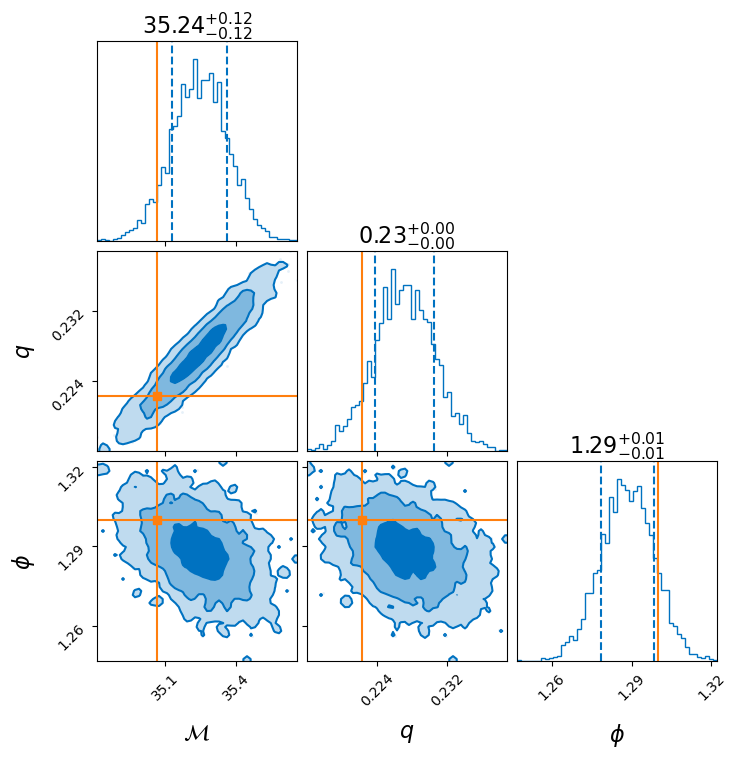

In [14]:
result.plot_corner(truths = {'chirp_mass' : bilby.gw.conversion.component_masses_to_chirp_mass(mass_1 = parameters['mass_1'],
                                                                                mass_2 = parameters['mass_2']),
                             'mass_ratio' : bilby.gw.conversion.component_masses_to_mass_ratio(mass_1 = parameters['mass_1'],
                                                                                mass_2 = parameters['mass_2']),
                             'phase' : parameters['phase']})

Text(0.5, 0, 'n')

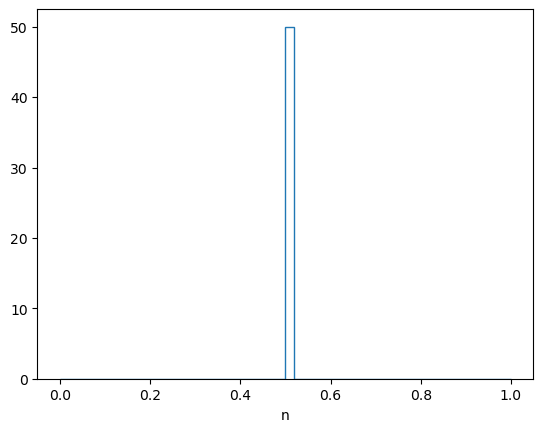

In [16]:
# we plot the morse factor separate because bilby does not like the bins
plt.figure()
plt.hist(np.array(result.posterior['n_phase']), bins = 50, histtype = 'step', density = True)
plt.xlabel("n")

We see that we recover a Morse factor of 0.5, meaning that we have properly found the image type. 